In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

from google.colab import files
uploaded = files.upload()

Saving viettri_quality.csv to viettri_quality.csv


In [2]:
# Function to smooth data
def smoothed(data, window_size=5):
    forecast_smoothed = data.rolling(window=window_size).mean()
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')
    return forecast_smoothed_filled

# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('viettri_quality.csv')
df0=df.reset_index()['pm25']
print(df0.shape)

# Làm mượt dữ liệu
df1 = smoothed(df0)

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1.shape)

(1920,)
(1920, 1)


In [3]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----29   Y=30
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+30 and Y=t+30

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [4]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 14s 102ms/step - loss: 0.0250
Epoch 2/100
24/24 [==============================] - 1s 50ms/step - loss: 0.0144
Epoch 3/100
24/24 [==============================] - 1s 56ms/step - loss: 0.0130
Epoch 4/100
24/24 [==============================] - 3s 123ms/step - loss: 0.0123
Epoch 5/100
24/24 [==============================] - 3s 128ms/step - loss: 0.0120
Epoch 6/100
24/24 [==============================] - 3s 133ms/step - loss: 0.0113
Epoch 7/100
24/24 [==============================] - 1s 51ms/step - loss: 0.0105
Epoch 8/100
24/24 [==============================] - 1s 49ms/step - loss: 0.0097
Epoch 9/100
24/24 [==============================] - 2s 76ms/step - loss: 0.0089
Epoch 10/100
24/24 [==============================] - 3s 123ms/step - loss: 0.0076
Epoch 11/100
24/24 [==============================] - 3s 125ms/step - loss: 0.0063
Epoch 12/100
24/24 [==============================] - 3s 141ms/step - loss: 0.0051
Epoch 13/100
24/2

In [5]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))

12/12 [==============================] - 1s 2ms/step


In [6]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

ytest=scaler.inverse_transform(test_data)

# Làm mượt dự đoán\
y_pred = smoothed(pd.Series(y_pred.flatten())).values.reshape(-1, 1)

# 12. Đánh giá mô hình
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100
print('Testing MAPE:', test_mape)

Testing RMSE: 26.870726941590164
Testing MAE: 23.652072456479072
Testing MAPE: 54.80931262338677


In [7]:
x_input=test_data[30:].reshape(1,-1)
x_input.shape

(1, 354)

In [8]:
# 13. Dự báo 90 ngày tiếp theo
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=354
i=0
while i < 90:
    #print(f"Starting iteration {i}, len(temp_input): {len(temp_input)}")
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, n_steps, 1))

    yhat = model.predict(x_input, verbose=0)
    #print(f"{i + 1} day output {yhat}")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i += 1

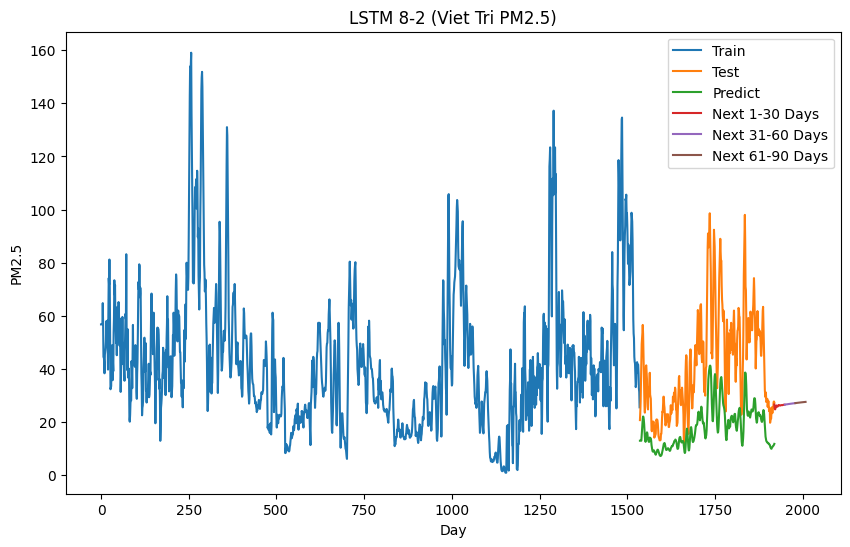

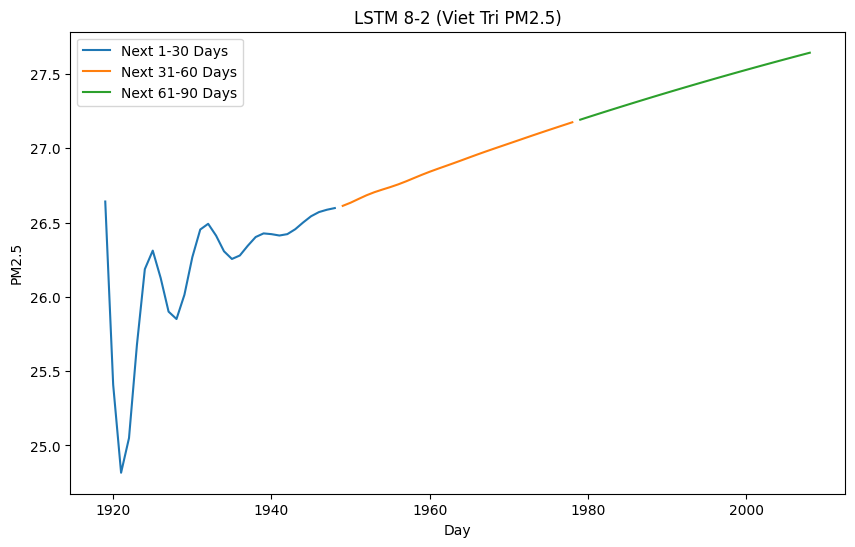

In [9]:
# 14.Vẽ hình
plt.figure(figsize=(10, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Next 1-30 Days', 'Next 31-60 Days', 'Next 61-90 Days'])
plt.title('LSTM 8-2 (Viet Tri PM2.5)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.show()

# Dự đoán 90 ngày tiếp theo
plt.figure(figsize=(10, 6))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Next 1-30 Days', 'Next 31-60 Days', 'Next 61-90 Days'])
plt.title('LSTM 8-2 (Viet Tri PM2.5)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.show()

In [10]:
print(scaler.inverse_transform(lst_output))

[[26.6417222 ]
 [25.4086633 ]
 [24.81609794]
 [25.04949504]
 [25.67626724]
 [26.18658456]
 [26.31116676]
 [26.12692213]
 [25.90044928]
 [25.85081887]
 [26.01373985]
 [26.26709977]
 [26.45323262]
 [26.49165615]
 [26.41204268]
 [26.30663693]
 [26.25505474]
 [26.27832311]
 [26.34378675]
 [26.40271226]
 [26.42708248]
 [26.42204174]
 [26.41285729]
 [26.42214534]
 [26.45521736]
 [26.50081706]
 [26.54258147]
 [26.57073283]
 [26.58637536]
 [26.59766227]
 [26.61257729]
 [26.63392919]
 [26.65913758]
 [26.68363494]
 [26.70450419]
 [26.72204199]
 [26.73871574]
 [26.75695044]
 [26.77757719]
 [26.79970133]
 [26.82168657]
 [26.84243575]
 [26.86187118]
 [26.88067564]
 [26.89961195]
 [26.91901913]
 [26.93868059]
 [26.9581584 ]
 [26.97712296]
 [26.99557662]
 [27.01376659]
 [27.03194243]
 [27.05022186]
 [27.06855544]
 [27.08679485]
 [27.10482237]
 [27.12261444]
 [27.14021581]
 [27.15772536]
 [27.17517135]
 [27.19254199]
 [27.20978549]
 [27.22686654]
 [27.24378514]
 [27.26055071]
 [27.27720326]
 [27.29375